# Two-layer custom CNN with MOSAIKS+KMeans

## Load utils

In [1]:
import os
import sys
import time
import inspect
import math
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import timm

from sklearn.cluster import KMeans


CURR_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing")

from dataset.pytorch_dataset import GeoLifeCLEF2022Dataset
from torch.utils.data import random_split, DataLoader
from mosaiks_utils import visualize_3d_patches, visTensor, normalize_patches

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load CIFAR10 dataset

In [2]:
trf = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 1

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=trf)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


## Define the model: two-layer CNN

In [3]:
# hyperparameters for the model
dataset = 'cifar10'
kernel_size = 8
num_filters = 100
mode = 'whiten' # options ['whiten', 'no_whiten']
zca_bias = 0.01
whiten = True
save_path = f"/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/{dataset}_two_layer_mosaiks_kmeans_{kernel_size}_{mode}_zca_{zca_bias}.pt"
max_iter = 100
random_state = np.random.RandomState(0)

In [4]:
model = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=num_filters, kernel_size=kernel_size, padding='same', bias=True),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),

      nn.Conv2d(in_channels=num_filters, out_channels=64, kernel_size=7, padding='same', bias=True),
      nn.LeakyReLU(),
      nn.MaxPool2d(2, stride=2),
    
      nn.AdaptiveAvgPool2d(9),
    
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(5184, 512), #50176
      nn.ReLU(),
      nn.Linear(512, len(classes))
      ) 
model(torch.rand((1, 3, 224, 224))).shape

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352660876/work/aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv2d(input, weight, bias, self.stride,


torch.Size([1, 10])

In [5]:
# model_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/two_layer_mosaiks_kmeans_7_whiten_allGeo_bs32_25eachimage_zcaBias_0.001.pt"
# model.load_state_dict(torch.load(model_path))

# filter_np = model[0].weight.data.numpy().reshape(100,-1)
# filter_np.shape
# plt.title('mosaiks+kmeans(2L) first conv layer values')
# plt.hist(filter_np);
# plt.rcParams['savefig.facecolor']='white'
# plt.savefig('mosaiks+kmeans(2L)_conv1_filter_histogram.png')

## Multi-layer Mosaiks

In [6]:
# model = nn.Sequential(
#       nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=7, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),

#       nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same', bias=True),
#       nn.LeakyReLU(),
#       nn.MaxPool2d(2, stride=2),
    
#       nn.AdaptiveAvgPool2d(9),
    
#       nn.Flatten(),
#       nn.Dropout(0.5),
#       nn.Linear(20736, 512), #50176
#       nn.ReLU(),
#       nn.Linear(512, num_species)
#       ) 
# model(torch.rand((1, 3, 224, 224))).shape

## slicing up the network

In [7]:
model

Sequential(
  (0): Conv2d(3, 100, kernel_size=(8, 8), stride=(1, 1), padding=same)
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(100, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): AdaptiveAvgPool2d(output_size=9)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=5184, out_features=512, bias=True)
  (10): ReLU()
  (11): Linear(in_features=512, out_features=10, bias=True)
)

## Manually set the indices of all convolution layers and the afterwards activation layers

In [8]:
# for 2-conv layers
conv_lyrs = [0, 3]
act_lyrs = [1, 4]

# for 4-conv layers
# conv_lyrs = [0, 2, 4, 6]
# act_lyrs = [1, 4, 7, 10]

In [9]:
for name, param in model.named_parameters():
    print(name, '---------------\t', param.shape)

0.weight ---------------	 torch.Size([100, 3, 8, 8])
0.bias ---------------	 torch.Size([100])
3.weight ---------------	 torch.Size([64, 100, 7, 7])
3.bias ---------------	 torch.Size([64])
9.weight ---------------	 torch.Size([512, 5184])
9.bias ---------------	 torch.Size([512])
11.weight ---------------	 torch.Size([10, 512])
11.bias ---------------	 torch.Size([10])


## Hooks for activation layers

In [10]:
features_dim = {}
def get_features(name):
    def hook(model, input, output):
        features_dim[name] = output.detach()
    return hook

In [11]:
# for 2-conv layers
model[1].register_forward_hook(get_features('relu_layer_1'))
model[4].register_forward_hook(get_features('relu_layer_4'))


# for 4-conv layers (without nn.AdaptivePool layer)
# model[1].register_forward_hook(get_features('relu_layer_1'))
# model[4].register_forward_hook(get_features('relu_layer_4'))
# model[7].register_forward_hook(get_features('relu_layer_7'))
# model[10].register_forward_hook(get_features('relu_layer_10'))

In [12]:
def get_featuremap_patches(train_dataloader, layer_idx, patch_size, max_patches, random_state):
    '''expects image shape of (width, height, n_channels)
    
    Parameters
    ----------
    train_dataloader: Dataset
                   dataloader for the training dataset to extract from
    
    layer_idx: int
               The index of the current feature map. 
               conv_lyrs[layer_idx] should return the real index of the current weights/parameter 
               
    patch_size: (int, int)
                Receptive field size or width and height of the extracted patch.
                
    max_patches: int
                 The number of extracted patches.
    
    random_state: int
                  Random state for reproducibility 
    Return
    ------
    patches: ndarrah
             final patches of size (max_patches, patch_size, n_channels)
    '''
    all_patches = []
    
    
    for batch in train_dataloader:
        images, target = batch
#         patches['rgb'] = trf(patches['rgb'])
        
        if layer_idx == 0:
            curr_feat_map = images.numpy()
        else:
            output = model(images)
            curr_feat_map = features_dim[f'relu_layer_{act_lyrs[layer_idx-1]}'].numpy()

        # grab one image from the batch
        img_idx = random.randint(0, batch_size-1)
        if img_idx >= curr_feat_map.shape[0]:
            img_idx = 0
        curr_feat_map = curr_feat_map[img_idx].transpose((1,2,0))

        # curr_feat_map: expected shape: (width, height, n_channels)
        # output shape: (max_patches, patch_size, n_channels)
        random_patches =  extract_patches_2d(curr_feat_map, 
                                 patch_size, 
                                 max_patches=max_patches,
                                 random_state=random_state)

        random_patches = np.reshape(random_patches, (len(random_patches), -1))

        all_patches.append(random_patches)
    
    return np.concatenate(all_patches, axis=0)

## Apply the K-Means to two conv layers

In [13]:
for layer_idx, relu_idx in enumerate(act_lyrs):
    if layer_idx == len(conv_lyrs):
        break
        
    print(f'for conv layer#{conv_lyrs[layer_idx]}')
    print(f'kmeans for output of relu act layer#{relu_idx}')   
    
    curr_param_idx = conv_lyrs[layer_idx]
    curr_param_sz = model[curr_param_idx].weight.data.shape
    num_clusters = curr_param_sz[0]  # number of output filters/kernels in a layer
    num_ch = curr_param_sz[1]    # number of channels
    patch_size = (curr_param_sz[2], curr_param_sz[3])  # filter/kernel's width and height
    
    if layer_idx == 0:
        max_patches = int(num_clusters/2)
    else: 
        max_patches = int(125000/len(trainloader))
            
    print(f'number of random patches from each image: {max_patches}')
    # Step#1: extract random patches  shape:(32064, 147)
    featmap_patches = get_featuremap_patches(trainloader,
                                             layer_idx=layer_idx,
                                             patch_size=patch_size,
                                             max_patches=max_patches,
                                             random_state=random_state)
    print(f'num of patches: {len(featmap_patches)}')
    # Step#2: normalize and whiten the patches
    whiten_patches, means, zca_mat = normalize_patches(featmap_patches, zca_bias=zca_bias, whiten=whiten)
    print(f'whiten_patches [min],[max],[mean],[std]: {whiten_patches.min():.3f}, {whiten_patches.max():.3f}, {whiten_patches.mean():.3f}, {whiten_patches.std():.3f}')
    
    # Step#3: apply kmeans to the whitened patches
    print(f'applying kmeans ...')
    kmeans = KMeans(n_clusters=num_clusters, 
                    random_state=random_state,
                    max_iter=max_iter,
                    verbose=False)
    kmeans_geo = kmeans.fit(whiten_patches)
    
    # change the weights of the corresponding conv layer
    print(f'Updating parameter#{curr_param_idx} with size: {curr_param_sz}')
    model[curr_param_idx].weight.data = torch.from_numpy(kmeans_geo.cluster_centers_.reshape(
                                            num_clusters, 
                                            patch_size[0], 
                                            patch_size[1],
                                            num_ch,).transpose(0, 3, 1, 2)
                                        )
    
    # save the model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved at {save_path}')

for conv layer#0
kmeans for output of relu act layer#1
number of random patches from each image: 50
num of patches: 2500000
zca bias 0.01
whiten_patches [min],[max],[mean],[std]: -9.157, 9.076, 0.000, 0.348
applying kmeans ...
Updating parameter#0 with size: torch.Size([100, 3, 8, 8])
for conv layer#3
kmeans for output of relu act layer#4
number of random patches from each image: 2
num of patches: 100000
zca bias 0.01
whiten_patches [min],[max],[mean],[std]: -0.387, 6.407, 0.000, 0.086
applying kmeans ...
Updating parameter#3 with size: torch.Size([64, 100, 7, 7])


In [14]:
# featmap_patches = np.random.rand(50000*4, 7*7*100)
# featmap_patches.shape

In [15]:
# whiten_patches, means, zca_mat = normalize_patches(featmap_patches, zca_bias=zca_bias, whiten=whiten)

In [16]:
def check_weights(weights_data):
    print(f'min: {weights_data.min()}')
    print(f'max: {weights_data.max()}')
    print(f'mean: {weights_data.mean()}')
    print(f'std: {weights_data.std()}')
    print(f'num_complex numbers: {np.iscomplex(weights_data.sum())}')
check_weights(model[0].weight.data.numpy())

min: -1.9269137382507324
max: 1.5295214653015137
mean: 1.6944293747656047e-05
std: 0.18723136186599731
num_complex numbers: False


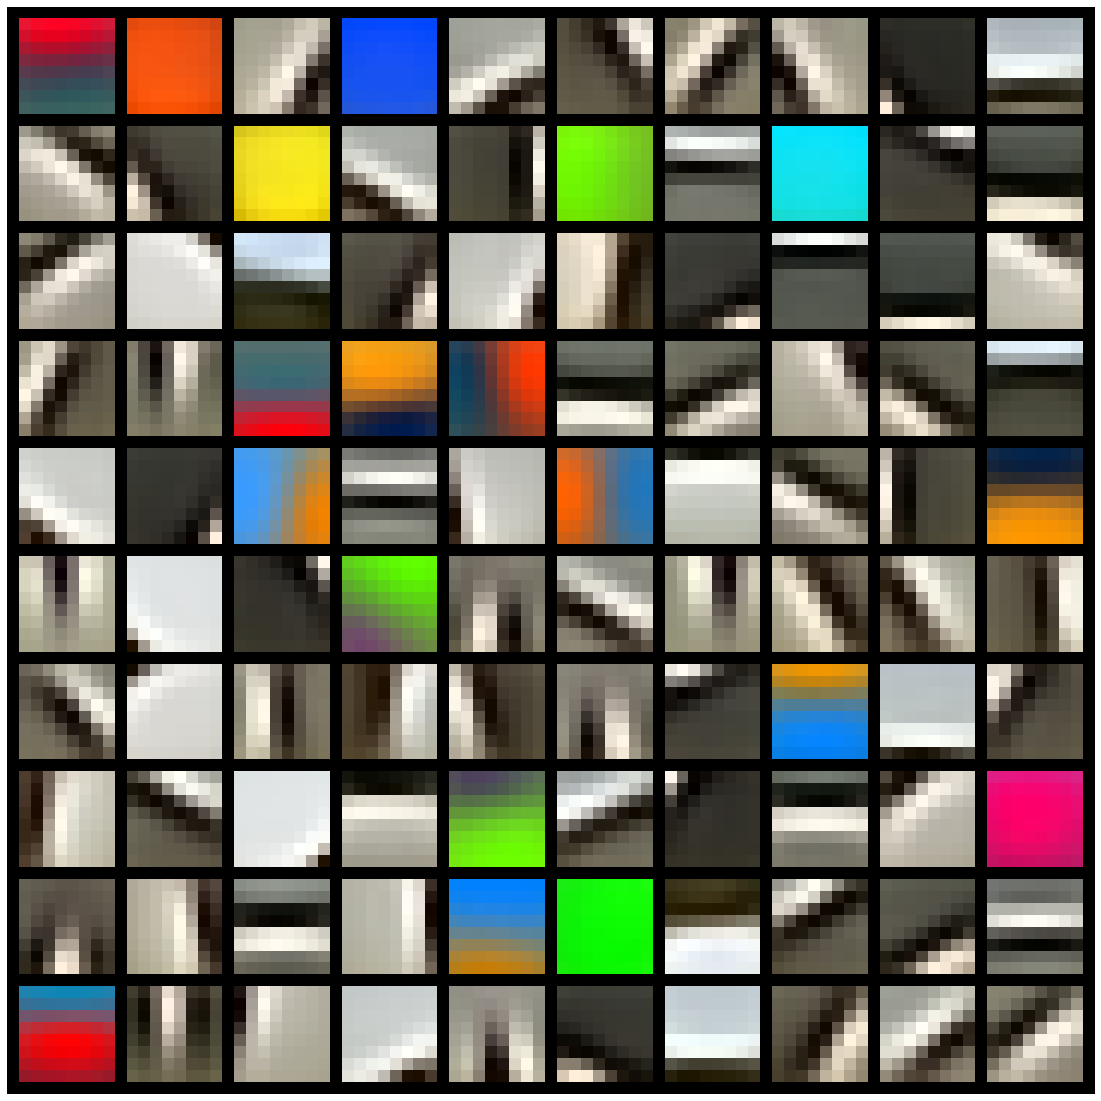

In [17]:
visTensor(model[0].weight.data, ch=0, nrow=10, allkernels=False)
plt.axis('off')
plt.ioff()
plt.rcParams['savefig.facecolor']='black'
plt.savefig(f'conv1_{dataset}_{str(kernel_size)}_{str(num_filters)}_{mode}_zcaBias_{zca_bias}.png')
plt.show()

In [18]:
weight_np = model[0].weight.data.numpy()
weight_np = np.interp(weight_np, (weight_np.min(), weight_np.max()), (-3, +3));

In [19]:
check_weights(weight_np)

min: -3.0
max: 3.0
mean: 0.3449445495152463
std: 0.32501351612720614
num_complex numbers: False


In [20]:
# m, s = weight_np.mean(), weight_np.std()
# weight_np = (weight_np-m)/(s+1e-9)
check_weights(weight_np)

min: -3.0
max: 3.0
mean: 0.3449445495152463
std: 0.32501351612720614
num_complex numbers: False


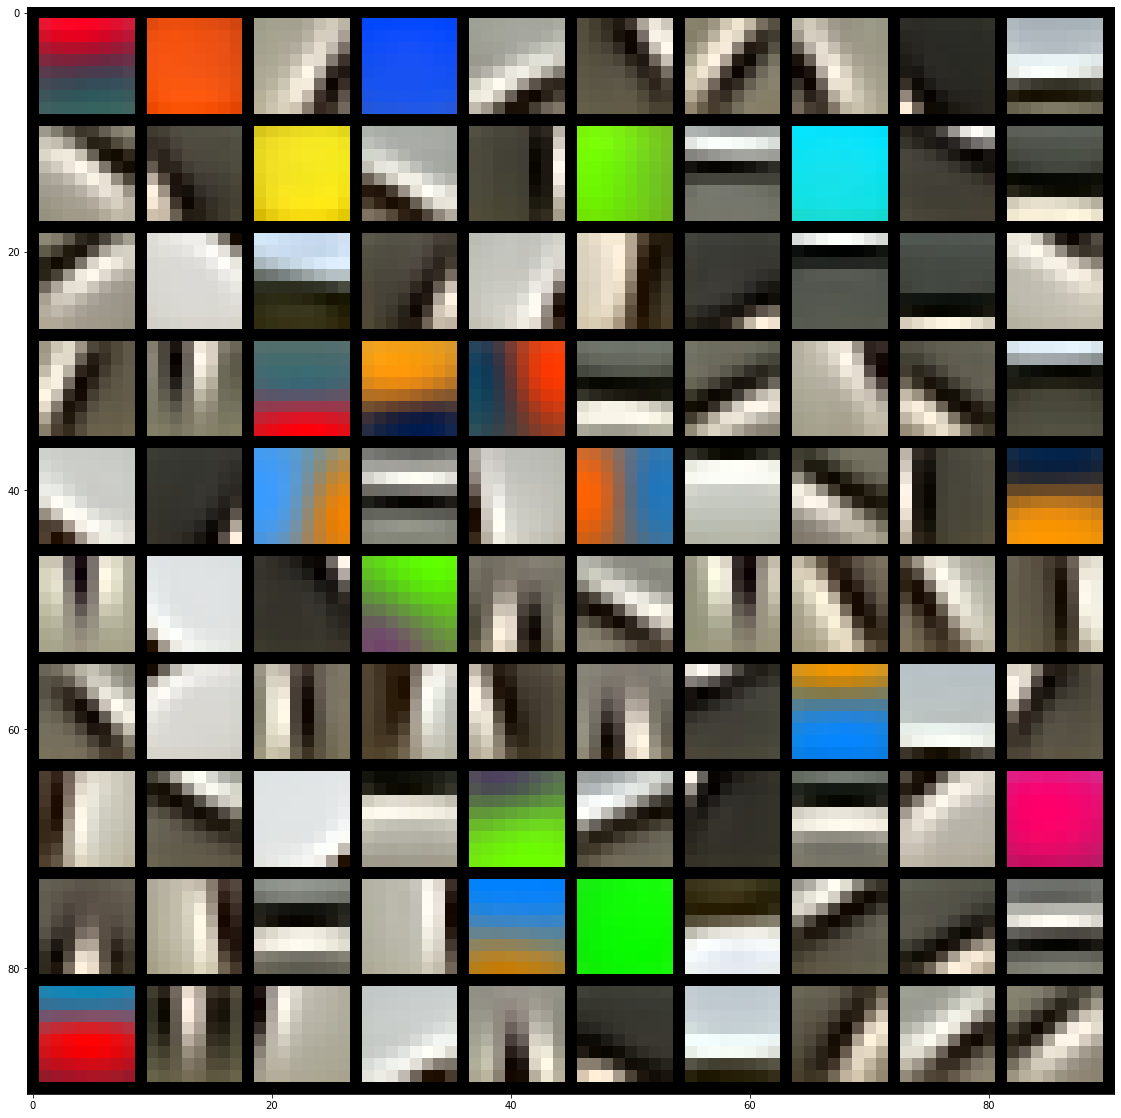

In [21]:
visTensor(torch.from_numpy(weight_np), ch=0, nrow=10, allkernels=False)

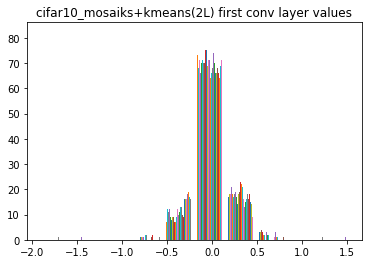

In [22]:
filter_np = model[0].weight.data.numpy().reshape(100,-1)
filter_np.shape
plt.title('cifar10_mosaiks+kmeans(2L) first conv layer values')
plt.hist(filter_np);
plt.rcParams['savefig.facecolor']='white'
plt.savefig('cifar10_mosaiks+kmeans(2L)_conv1_filter_histogram.png')